# Depth Analysis

In [1]:
import os
import sys

import re
import pickle
from tqdm import tqdm

import numpy as np
import ccdproc as ccdp
import pandas as pd
from scipy.interpolate import UnivariateSpline
from astropy.convolution import Moffat2DKernel
#from adjustText import adjust_text
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#%matplotlib tk
import matplotlib.ticker as mtick
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'

import imgprocesslib.imageprocess as ip
from imgprocesslib import homedir, ddir
import imgprocesslib.calibrationcpu as clb
import imgprocesslib.makecatologuecpu as mkcat
from imgprocesslib.calibrationcpu import get_hist_info, lim_mag
from astropy.stats import mad_std as mad
import multiprocessing as mp

#from IPython.display import clear_output as clears

```
print(f"Current GPU memory usage: {torch.cuda.memory_allocated() / 1e9} GB")
print(f"Peak GPU memory usage: {torch.cuda.max_memory_allocated() / 1e9} GB")

In [2]:
def subplots_centered(nrows, ncols, figsize, nfigs, dpi=100, sharex=False, sharey=False):
    """
    Modification of matplotlib plt.subplots(),
    useful when some subplots are empty.
    
    It returns a grid where the plots
    in the **last** row are centered.
    
    Inputs
    ------
        nrows, ncols, figsize: same as plt.subplots()
        nfigs: real number of figures
    """
    assert nfigs < nrows * ncols, "No empty subplots, use normal plt.subplots() instead"
    
    fig = plt.figure(figsize=figsize, dpi=dpi)
    axs = []
    
    m = nfigs % ncols
    m = range(1, ncols+1)[-m]  # subdivision of columns
    gs = gridspec.GridSpec(nrows, m*ncols)

    for i in range(0, nfigs):
        row = i // ncols
        col = i % ncols

        if row == nrows-1: # center only last row
            off = int(m * (ncols - nfigs % ncols) / 2)
        else:
            off = 0

        ax = plt.subplot(gs[row, m*col + off : m*(col+1) + off])
        axs.append(ax)
        
    return fig, axs

In [3]:
jades_files_path = ccdp.ImageFileCollection(ddir).files_filtered(include_path=True)

In [ ]:
aper_size = 5.83

params = {'dpi': 200,
          'step_size': 1,
          'tolerance': 1e-1,
          'SAVE': False
         }

img = clb.SkyCalibration(jades_files_path[12], aper_size, **params)

In [ ]:
img.plot_map(USE_SEG_MAP=False, PLOT_APERS=True)
plt.show()

In [4]:
with open('Output/calibration_f444w_apers_5.83_tol_0.1.pkl', 'rb') as file:
    skyflux = pickle.load(file)['sky_flux']

In [5]:
## SANITY CHECK BLOCK ##

# Use the unique function to get unique elements and their counts
unique_numbers, counts = np.unique(skyflux, return_counts=True)

# Find the index of the most common number
most_common_index = np.argmax(counts)

# Get the most common number and its count
most_common_number = unique_numbers[most_common_index]
most_common_count = counts[most_common_index]

print(f"The most common number is {most_common_number}, appearing {most_common_count} times.")

len(skyflux)

The most common number is -0.005529886102306136, appearing 1 times.


208602

In [6]:
skyflux

array([ 0.00039116, -0.00055219,  0.00334061, ...,  0.00627123,
        0.00024088,  0.00219497])

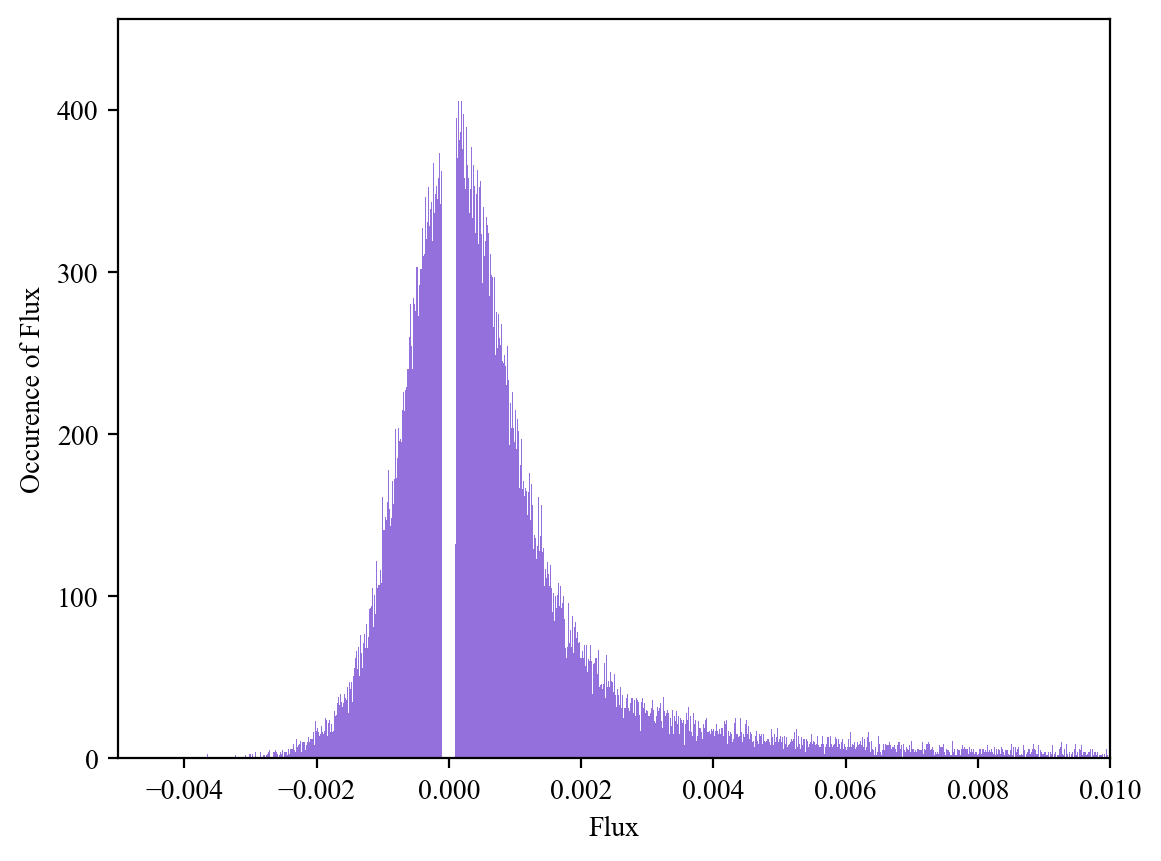

In [6]:
plt.figure(dpi=200)
plt.hist(skyflux, bins=10000, color='mediumpurple')
plt.xlim(-0.005, 0.010)
plt.xlabel("Flux")
plt.ylabel("Occurence of Flux")
plt.show()

```
x, y = get_hist_info(skyflux, bins=10000)

plt.figure(dpi=200)
plt.scatter(x, y, alpha=0.5, s=5, color='mediumpurple')
plt.xlim(-0.015, 0.05)
plt.xlabel("Flux")
plt.ylabel("Occurence of Flux")
plt.show()
```

5-sigma limiting magnitude

In [7]:
jades_files_path[14:]

['c:\\Users\\blybe\\OneDrive - University of Edinburgh\\MPhys Project/Jades_files/jwst_jades-gs_dr1_f480m_30mas_microJy.fits',
 'c:\\Users\\blybe\\OneDrive - University of Edinburgh\\MPhys Project/Jades_files/jwst_jades-gs_dr1_f606w_30mas_microJy.fits',
 'c:\\Users\\blybe\\OneDrive - University of Edinburgh\\MPhys Project/Jades_files/jwst_jades-gs_dr1_f775w_30mas_microJy.fits',
 'c:\\Users\\blybe\\OneDrive - University of Edinburgh\\MPhys Project/Jades_files/jwst_jades-gs_dr1_f814w_30mas_microJy.fits',
 'c:\\Users\\blybe\\OneDrive - University of Edinburgh\\MPhys Project/Jades_files/jwst_jades-gs_dr1_f850lp_30mas_microJy.fits',
 'c:\\Users\\blybe\\OneDrive - University of Edinburgh\\MPhys Project/Jades_files/jwst_nircam_f444w_psf_stackall.fits']

````
aper_size = 11.67

results = []
for file in tqdm(jades_files_path[14:], total=len(jades_files_path[14:])):
    params = {#'dpi': 200,
            'bins': 50,
            'step_size': 10,
            'tolerance': 1e-1,
            #'processors': mp.cpu_count() - 1
            }
            
    results.append(clb.SkyCalibration(file, aper_size, **params))
````

In [9]:
def worker_wrapper(argkwargs):
    datafile, aper_size, kwargs = argkwargs
    img_objs = clb.SkyCalibration(datafile, aper_size, **kwargs)
    img_objs.save(file_type='csv')

    with tqdm.external_write_mode():
        pbar.update()

        
aper_size = 11.67
processors = mp.cpu_count() - 1
params = {
    'bins': 50,
    'step_size': 10,
    'tolerance': 1e-1,
    'SAVE': False
}
argkwargs = [(file, aper_size, params) for file in jades_files_path]
pbar = tqdm(jades_files_path, total=len(jades_files_path))

with mp.Pool(processes=processors) as pool:
    pbar.refresh()
    
    for _ in pool.imap_unordered(worker_wrapper, argkwargs):
        pbar.update()

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
import time

aper_size = 5.83
img_objs = []

pbar = tqdm(jades_files_path, total=len(jades_files_path))

for file in jades_files_path:
    params = {#'dpi': 200,
              #'bins': 50,
              'step_size': 1,
              'tolerance': 1e-1,
              'SAVE': False
             }

    pbar.refresh()
    start_time = time.time()
    img_objs = clb.SkyCalibration(file, aper_size, **params)

    pbar.update()
    img_objs.save()
    img_objs.save(file_type='txt')

    # Clear the img_objs variable from memory
    del img_objs 

In [5]:
filters_list  = [{'Telescope': 'NIRCam Short Wavelength',
                  'filters': ['090w', '115w', '150w', '182m', '200w', '210m'],
                  'colours': ['#B7AAEE', '#AF47FF', '#5C55B3', '#99CCFF', '#00A8E0', '#0101DF']},
                 {'Telescope': 'NIRCam Long Wavelength',
                  'filters': ['277w', '335m', '356w', '410m', '430m', '444w', '460m', '480m'],
                  'colours': ['#256E37', '#B58653', '#A84900', '#0B412B', '#51C083', '#C8D96F', '#89931E', '#6DB41D']},
                 {'Telescope': 'HST ACS', 
                  'filters': ['435w', '606w', '775w', '814w', '850lp'],
                  'colours': ['#660000', '#DD0000', '#DB2E6B', 'orange', '#E0D100']},
                ]

In [18]:
for file in os.listdir(os.path.join(homedir, "Output")):
    if 'calibration' in file and '0.1' in file and '5.83' in file and file.endswith('.pkl'):
        print(file)

calibration_f090w_apers_5.83_tol_0.1.pkl
calibration_f115w_apers_5.83_tol_0.1.pkl
calibration_f150w_apers_5.83_tol_0.1.pkl
calibration_f182m_apers_5.83_tol_0.1.pkl
calibration_f200w_apers_5.83_tol_0.1.pkl
calibration_f210m_apers_5.83_tol_0.1.pkl
calibration_f277w_apers_5.83_tol_0.1.pkl
calibration_f335m_apers_5.83_tol_0.1.pkl
calibration_f356w_apers_5.83_tol_0.1.pkl
calibration_f410m_apers_5.83_tol_0.1.pkl
calibration_f430m_apers_5.83_tol_0.1.pkl
calibration_f435w_apers_5.83_tol_0.1.pkl
calibration_f444w_apers_5.83_tol_0.1.pkl
calibration_f460m_apers_5.83_tol_0.1.pkl
calibration_f480m_apers_5.83_tol_0.1.pkl
calibration_f606w_apers_5.83_tol_0.1.pkl
calibration_f775w_apers_5.83_tol_0.1.pkl
calibration_f814w_apers_5.83_tol_0.1.pkl
calibration_f850lp_apers_5.83_tol_0.1.pkl


In [19]:
skyflux_data = []
allfilename = []
for file in os.listdir(os.path.join(homedir, "Output")):
    if 'calibration' in file and '0.1' in file and '5.83' in file and file.endswith('.pkl'):
        with open(homedir+"Output/"+file, 'rb') as data:
            skyflux_data.append(pickle.load(data)['sky_flux'])

allfilename = [name.rsplit('_', 5)[1] for name in os.listdir(os.path.join(homedir, "Output")) if 'calibration' and '0.1' and '5.83' in name and name.endswith('.pkl')]

In [20]:
SCATTER = True
fig, axes = subplots_centered(nrows=2, ncols=2, figsize=(9,7), nfigs=3, dpi=700, sharex=True, sharey=True)

for i, (ax, list_fil) in enumerate(zip(axes, filters_list)): #(axes, os.listdir(os.path.join(homedir, "Output")), allfilename   #(ax, file, filename)            
    ax.title.set_text('{}'.format(list_fil['Telescope']))

    if i != 0:
        ax.sharex(axes[0])
        ax.sharey(axes[0])
        
    for fil, col in zip(list_fil['filters'], list_fil['colours']):
        for data, name in zip(skyflux_data, allfilename):
            if re.compile('{}'.format(fil)).findall(name):
                if SCATTER:
                    x, y = get_hist_info(data, bins=10000)
                    ax.scatter(x, y/np.max(y)*100, alpha=0.2, s=0.5, label='{}'.format(name), c=col)
                else:
                    x, y = get_hist_info(data, bins=1000)
                    s = UnivariateSpline(x, y, s=100) #(0 if re.compile(r'HST').findall(list_fil['Telescope']) else 100)
                    xs = np.linspace(np.min(x), np.max(x), 100)
                    ys = s(xs)
                    if re.compile(r'm').findall(name):
                        ax.plot(xs, ys/np.max(ys)*100, label='{}'.format(name), linestyle='--', linewidth=0.75, alpha=0.8, c=col)
                    else:
                        ax.plot(xs, ys/np.max(ys)*100, label='{}'.format(name), linewidth=0.75, alpha=0.8, c=col)
                
    ax.grid(True, color="gray", linewidth="0.5", linestyle = "-", alpha=0.2)
    ax.set_xlabel('Flux')
    ax.set_ylabel('Occurence of Flux')
    leg = ax.legend(loc=1, ncol=2, prop={'size' : 12}, handlelength=0.2, columnspacing=0.8, frameon=False, handletextpad=0.4)
    for lh in leg.legend_handles: 
        lh.set_alpha(1)
        if SCATTER:
            lh.set_sizes([4])

#fig.suptitle("Sky Background Flux Distribution")
plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(4))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(4))
plt.xlim(-0.025, 0.035)
plt.ylim(0, 100.5)
fig.tight_layout()
plt.show()

In [8]:
data_table = {
    'Filter': allfilename,
    'Sigma': [],
    'MAD Estimates': [],
    'Limiting Magnitudes': []
}

for skyflux in skyflux_data:
    data_table['Sigma'].append(np.std(skyflux))
    data_table['MAD Estimates'].append(mad(skyflux))
    data_table['Limiting Magnitudes'].append(lim_mag(data_table['MAD Estimates'][-1]))

data_table['Sigma'] = np.array(data_table['Sigma'])
data_table['MAD Estimates'] = np.array(data_table['MAD Estimates'])
data_table['Limiting Magnitudes'] = np.array(data_table['Limiting Magnitudes'])

In [9]:
data_table = pd.DataFrame(data_table)
styler = data_table.style
format_dict = {
    'Sigma': '{:0.3e}',
    'MAD Estimates': '{:0.3e}',
    'Limiting Magnitudes': '{:0}'
}
data_table_ = styler.format(format_dict)
data_table_

ValueError: All arrays must be of the same length

Useless Plot
```
plt.figure(dpi=400)
plt.scatter(np.linspace(1, 19, 19), data_table['Sigma'], label="Sigma", s=15)
plt.scatter(np.linspace(1, 19, 19), data_table['MAD Estimates'], label="MAD", s=15)
plt.scatter(np.linspace(1, 19, 19), data_table['MAD Estimates']*1.46, label="MAD x 1.46", s=15)
plt.ylabel("Estimate value")
plt.legend()
plt.show()

```
cols = [c for list_fil in filters_list for c in list_fil['colours']]
labs = [l for list_fil in filters_list for l in list_fil['filters']]

Useless Plot
```
plt.figure(dpi=400)
plt.scatter(lim_mag_list, mad_est_list, s=8, c=cols, marker='.', alpha=0.9)

annotation_points = [(x, y) for x, y in zip(lim_mag_list, mad_est_list)]
annotations = [lab for lab in labs]

for i, lab in enumerate(labs):
    plt.scatter([], [], color=cols[i], label=lab)
    #plt.annotate(lab, (lim_mag_list[i], mad_est_list[i]), textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)

texts = adjust_text([plt.text(x, y, lab, fontsize=5.5, ha='left') for x, y, lab in zip(lim_mag_list, mad_est_list, labs)]
                    #arrowprops=dict(arrowstyle='-', color='gray')
                    )

leg = plt.legend(loc=1, ncol=4, prop={'size' : 12}, handlelength=0.5, columnspacing=0.3)
for lh in leg.legend_handles: 
    #lh.set_alpha(0.9)
    lh.set_sizes([2])

plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(2))
plt.ylabel("Median Absolute Deviation (MAD)")
plt.xlabel("Limiting Magnitude (at 5σ)")
plt.show()

## Sigma limit of Convolution

In [1]:
import os
import sys

import re
import pickle
from tqdm import tqdm

import numpy as np
import ccdproc as ccdp
import pandas as pd
from scipy.interpolate import UnivariateSpline
from astropy.convolution import Moffat2DKernel
#from adjustText import adjust_text
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#%matplotlib tk
import matplotlib.ticker as mtick
import matplotlib as mpl
#mpl.rcParams['font.family'] = 'Times New Roman'

import imgprocesslib.imageprocess as ip
from imgprocesslib import homedir, ddir
import imgprocesslib.calibrationcpu as clb
import imgprocesslib.makecatologuecpu as mkcat
from imgprocesslib.calibrationcpu import get_hist_info, lim_mag
from astropy.stats import mad_std as mad
import multiprocessing as mp

#from IPython.display import clear_output as clears

In [2]:
def subplots_centered(nrows, ncols, figsize, nfigs, dpi=100, sharex=False, sharey=False):
    """
    Modification of matplotlib plt.subplots(),
    useful when some subplots are empty.
    
    It returns a grid where the plots
    in the **last** row are centered.
    
    Inputs
    ------
        nrows, ncols, figsize: same as plt.subplots()
        nfigs: real number of figures
    """
    assert nfigs < nrows * ncols, "No empty subplots, use normal plt.subplots() instead"
    
    fig = plt.figure(figsize=figsize, dpi=dpi)
    axs = []
    
    m = nfigs % ncols
    m = range(1, ncols+1)[-m]  # subdivision of columns
    gs = gridspec.GridSpec(nrows, m*ncols)

    for i in range(0, nfigs):
        row = i // ncols
        col = i % ncols

        if row == nrows-1: # center only last row
            off = int(m * (ncols - nfigs % ncols) / 2)
        else:
            off = 0

        ax = plt.subplot(gs[row, m*col + off : m*(col+1) + off])
        axs.append(ax)
        
    return fig, axs

In [3]:
gammas = [3.1, 3.22, 3.225, 3.325, 3.325, 3.4, 2.665, 2.1, 1.8, 1.5, 1.8, 3.25, 1.4, 1., 3.2, 3.3, 3.3, 2.1]
alphas = [2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.3, 2.3, 2.3, 2.2]

In [4]:
d_array = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]

In [5]:
jades_files_path = ccdp.ImageFileCollection(ddir).files_filtered(include_path=True)
jades_files_path

['c:\\Users\\blybe\\OneDrive - University of Edinburgh\\MPhys Project/Jades_files/jwst_jades-gs_dr1_f090w_30mas_microJy.fits',
 'c:\\Users\\blybe\\OneDrive - University of Edinburgh\\MPhys Project/Jades_files/jwst_jades-gs_dr1_f115w_30mas_microJy.fits',
 'c:\\Users\\blybe\\OneDrive - University of Edinburgh\\MPhys Project/Jades_files/jwst_jades-gs_dr1_f150w_30mas_microJy.fits',
 'c:\\Users\\blybe\\OneDrive - University of Edinburgh\\MPhys Project/Jades_files/jwst_jades-gs_dr1_f182m_30mas_microJy.fits',
 'c:\\Users\\blybe\\OneDrive - University of Edinburgh\\MPhys Project/Jades_files/jwst_jades-gs_dr1_f200w_30mas_microJy.fits',
 'c:\\Users\\blybe\\OneDrive - University of Edinburgh\\MPhys Project/Jades_files/jwst_jades-gs_dr1_f210m_30mas_microJy.fits',
 'c:\\Users\\blybe\\OneDrive - University of Edinburgh\\MPhys Project/Jades_files/jwst_jades-gs_dr1_f277w_30mas_microJy.fits',
 'c:\\Users\\blybe\\OneDrive - University of Edinburgh\\MPhys Project/Jades_files/jwst_jades-gs_dr1_f335m_30mas

In [6]:
filters_list  = [{'Telescope': 'NIRCam Short Wavelength',
                  'filters': ['090w', '115w', '150w', '182m', '200w', '210m'],
                  'colours': ['#B7AAEE', '#AF47FF', '#5C55B3', '#99CCFF', '#00A8E0', '#0101DF']},
                 {'Telescope': 'NIRCam Long Wavelength',
                  'filters': ['277w', '335m', '356w', '410m', '430m', '444w', '460m', '480m'],
                  'colours': ['#256E37', '#B58653', '#A84900', '#0B412B', '#51C083', '#C8D96F', '#89931E', '#6DB41D']},
                 {'Telescope': 'HST ACS', 
                  'filters': ['435w', '606w', '775w', '814w', '850lp'],
                  'colours': ['#660000', '#DD0000', '#DB2E6B', 'orange', '#E0D100']},
                ]

In [7]:
filters_list  = [{'Telescope': 'NIRCam Short Wavelength',
                  'filters': ['090w', '115w', '150w', '182m', '200w', '210m'],
                  'colours': ['#B7AAEE', '#AF47FF', '#5C55B3', '#99CCFF', '#00A8E0', '#0101DF']},
                 {'Telescope': 'NIRCam Long Wavelength',
                  'filters': ['277w', '335m', '356w', '410m', '430m', '444w', '460m', '480m'],
                  'colours': ['#1CE026', '#904300', '#FFB370', '#2C302E', '#6CF4C4', '#C8D96F', '#909590', '#85AE5F']},
                 {'Telescope': 'HST ACS', 
                  'filters': ['435w', '606w', '775w', '814w', '850lp'],
                  'colours': ['#660000', '#DD0000', '#DB2E6B', 'orange', '#E0D100']},
                ]

In [36]:
aper_size = 5.83 

params = {#'dpi': 200,
          #'bins': 50,
          'step_size': 10,
          'tolerance': 1e-1,
          'SAVE': True,
          'filetype': ('txt', 'pkl'),
          'CONVOLVE': True,
          }

c_params = {
    'detThesh': d_array,
    'gamma': gammas,
    'alpha': alphas,
}

clb.init_SkyCalibration(jades_files_path, aper_size, change_kwargs=c_params, **params)

  0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
for file in sorted(os.listdir(os.path.join(homedir, "Output"))):
    if 'convolved' in file and '0.1' in file and '5.83' in file and file.endswith('.pkl') and 'photometric' not in file:
        print(file)

convolved_depths_f090w_apers_5.83_tol_0.1_detThresh_2.pkl
convolved_depths_f115w_apers_5.83_tol_0.1_detThresh_2.pkl
convolved_depths_f150w_apers_5.83_tol_0.1_detThresh_2.pkl
convolved_depths_f182m_apers_5.83_tol_0.1_detThresh_2.pkl
convolved_depths_f200w_apers_5.83_tol_0.1_detThresh_2.pkl
convolved_depths_f210m_apers_5.83_tol_0.1_detThresh_2.pkl
convolved_depths_f277w_apers_5.83_tol_0.1_detThresh_2.pkl
convolved_depths_f335m_apers_5.83_tol_0.1_detThresh_2.pkl
convolved_depths_f356w_apers_5.83_tol_0.1_detThresh_2.pkl
convolved_depths_f410m_apers_5.83_tol_0.1_detThresh_2.pkl
convolved_depths_f430m_apers_5.83_tol_0.1_detThresh_2.pkl
convolved_depths_f435w_apers_5.83_tol_0.1_detThresh_2.pkl
convolved_depths_f444w_apers_5.83_tol_0.1_detThresh_2.pkl
convolved_depths_f460m_apers_5.83_tol_0.1_detThresh_2.pkl
convolved_depths_f480m_apers_5.83_tol_0.1_detThresh_2.pkl
convolved_depths_f606w_apers_5.83_tol_0.1_detThresh_2.pkl
convolved_depths_f775w_apers_5.83_tol_0.1_detThresh_2.pkl
convolved_dept

In [9]:
skyflux_data = []
allfilename = []
for file in os.listdir(os.path.join(homedir, "Output")):
    if 'convolved' in file and '0.1' in file and '5.83' in file and file.endswith('.pkl') and 'photometric' not in file:
        with open(homedir+"Output/"+file, 'rb') as data:
            skyflux_data.append(pickle.load(data)['sky_flux'])

            allfilename.append(file.rsplit('_', 7)[1])

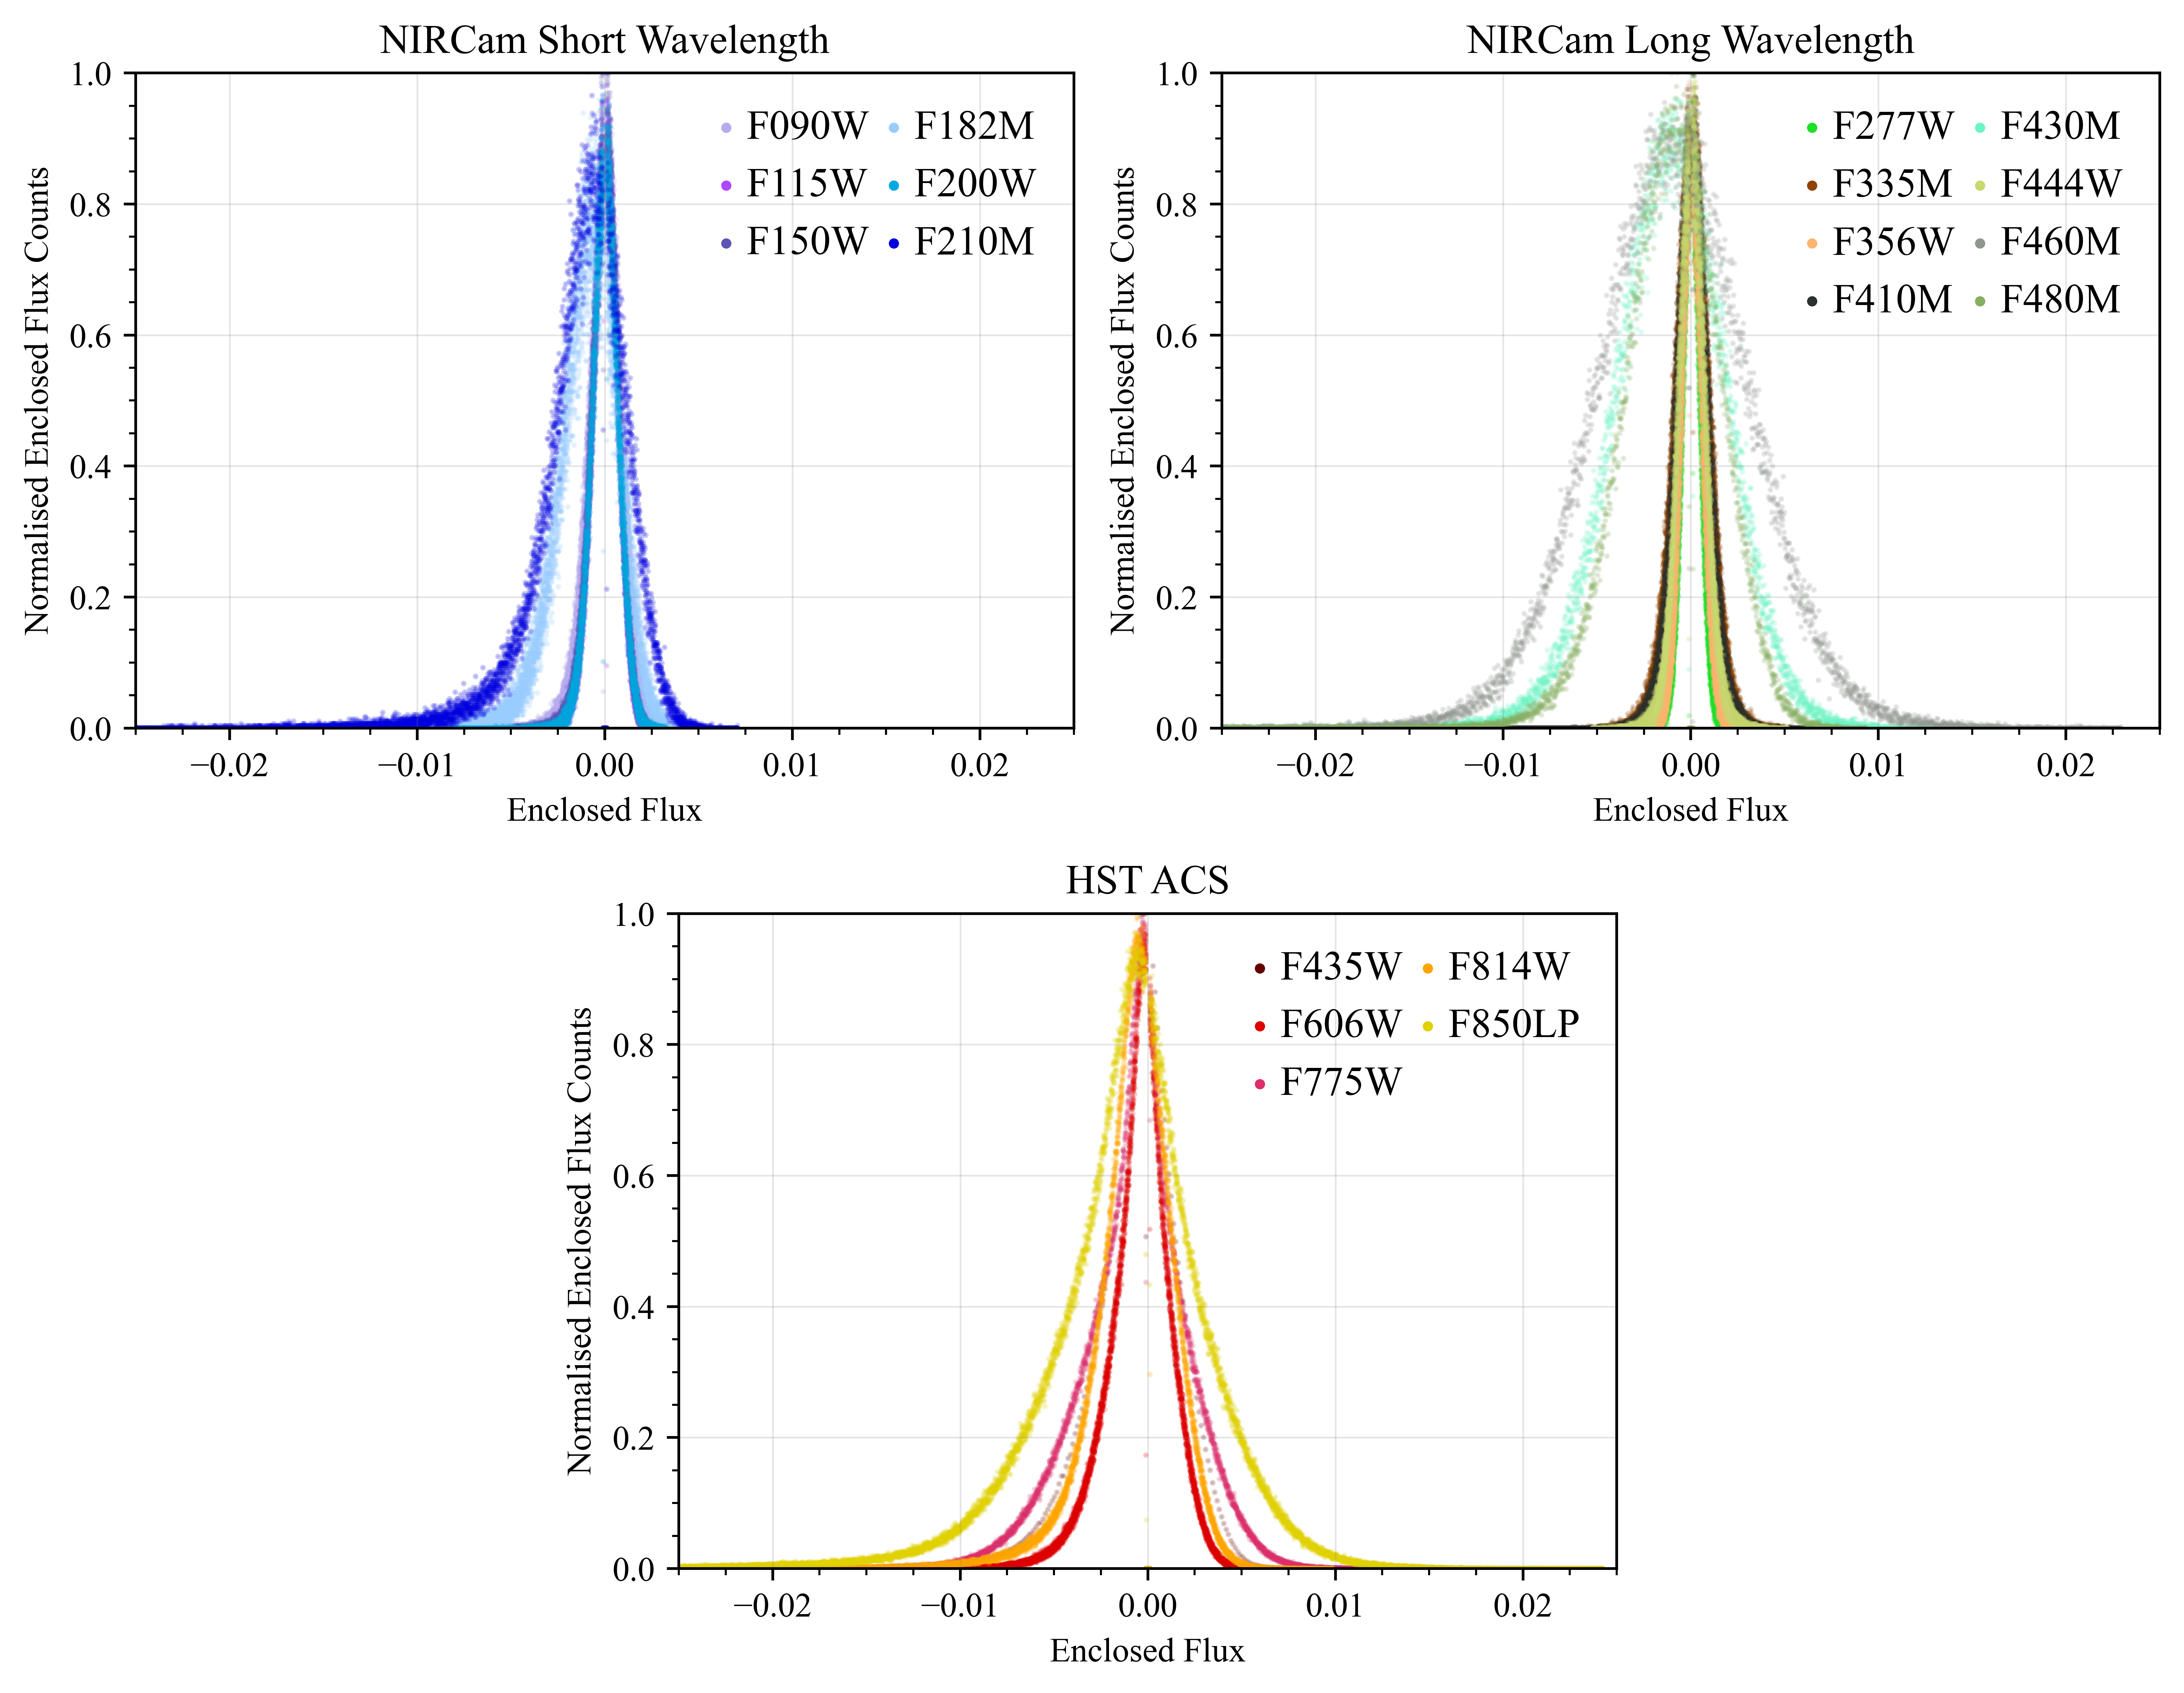

In [10]:
SCATTER = True
fig, axes = subplots_centered(nrows=2, ncols=2, figsize=(9,7), nfigs=3, dpi=700, sharex=True, sharey=True)

for i, (ax, list_fil) in enumerate(zip(axes, filters_list)): #(axes, os.listdir(os.path.join(homedir, "Output")), allfilename   #(ax, file, filename)            
    ax.title.set_text('{}'.format(list_fil['Telescope']))

    if i != 0:
        ax.sharex(axes[0])
        ax.sharey(axes[0])
        
    for fil, col in zip(list_fil['filters'], list_fil['colours']):
        for data, name in zip(skyflux_data, allfilename):
            if re.compile('{}'.format(fil)).findall(name):
                if SCATTER:
                    x, y = get_hist_info(data, bins=10000)
                    ax.scatter(x, y/np.max(y), alpha=0.2, s=0.5, label='{}'.format(name.upper()), c=col)
                else:
                    x, y = get_hist_info(data, bins=1000)
                    s = UnivariateSpline(x, y, s=100) #(0 if re.compile(r'HST').findall(list_fil['Telescope']) else 100)
                    xs = np.linspace(np.min(x), np.max(x), 100)
                    ys = s(xs)
                    if re.compile(r'm').findall(name):
                        ax.plot(xs, ys/np.max(ys)*100, label='{}'.format(name.upper()), linestyle='--', linewidth=0.75, alpha=0.8, c=col)
                    else:
                        ax.plot(xs, ys/np.max(ys)*100, label='{}'.format(name.upper()), linewidth=0.75, alpha=0.8, c=col)
                
    ax.grid(True, color="gray", linewidth="0.5", linestyle = "-", alpha=0.2)
    ax.set_xlabel('Enclosed Flux')
    ax.set_ylabel('Normalised Enclosed Flux Counts')
    leg = ax.legend(loc=1, ncol=2, prop={'size' : 12}, handlelength=0.2, columnspacing=0.5, frameon=False, handletextpad=0.4)
    for lh in leg.legend_handles: 
        lh.set_alpha(1)
        if SCATTER:
            lh.set_sizes([4])

#fig.suptitle("Convolved Sky Background Flux Distribution")
plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(4))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(4))
plt.xlim(-0.025, 0.025)
plt.ylim(0, 1.0)
fig.tight_layout()
plt.show()

In [10]:
data_table = {
    'Filter': allfilename,
    'Sigma': [],
    'MAD Estimates': [],
    'Limiting Magnitudes': []
}

for skyflux in skyflux_data:
    data_table['Sigma'].append(np.std(skyflux))
    data_table['MAD Estimates'].append(mad(skyflux))
    data_table['Limiting Magnitudes'].append(lim_mag(data_table['MAD Estimates'][-1]))

data_table['Sigma'] = np.array(data_table['Sigma'])
data_table['MAD Estimates'] = np.array(data_table['MAD Estimates'])
data_table['Limiting Magnitudes'] = np.array(data_table['Limiting Magnitudes'])

In [13]:
data_table = pd.DataFrame(data_table)
styler = data_table.style
format_dict = {
    'Sigma': '{:0.3e}',
    'MAD Estimates': '{:0.3e}',
    'Limiting Magnitudes': '{:0}'
}
data_table_ = styler.format(format_dict)
data_table_

In [14]:
data_table.to_csv('Output/convolved_depths_5.83_tol_0.1_detThest_2.csv', index=False)

In [97]:
deplist = np.array([2.347, 2.004, 2.147, 4.885, 2.155, 6.454, 1.524, 2.245, 1.543, 2.079, 6.736, 5.341, 
           1.739, 8.407, 7.033, 3.962, 6.459, 5.578, 9.158])
deplist *= 0.001
deplist

array([0.002347, 0.002004, 0.002147, 0.004885, 0.002155, 0.006454,
       0.001524, 0.002245, 0.001543, 0.002079, 0.006736, 0.005341,
       0.001739, 0.008407, 0.007033, 0.003962, 0.006459, 0.005578,
       0.009158])

In [98]:
for file in os.listdir(os.path.join(homedir, "Output")):
    if 'convolved' in file and 'photometric' in file and file.endswith('.pkl'):
        data = pickle.load(open(homedir+"Output/"+file, 'rb'))

In [99]:
filters_list = list(data.keys())[5:]

In [100]:
for dep, fit in zip(deplist, filters_list):
    data[fit+'_err'] = np.ones(len(data[fit]))*dep

data = pd.DataFrame(data)
pd.set_option('display.max_rows', None)

In [101]:
#data.to_csv('Output/photometric_convolved_catalogue_f356w_apers_5.83_tol_0.1_detThresh_2_withErrors.txt', index=False, sep=' ')

In [102]:
print(len(data['f356w']))
data.drop(data[data['f356w_err']*5 > data['f356w']].index, inplace=True)
print(len(data['f356w']))

36645
13318


In [104]:
#data.to_csv('Output/photometric_convolved_catalogue_f356w_apers_5.83_tol_0.1_detThresh_2_withErrors_5sigmaCut.txt', index=False, sep=' ')

In [1]:
import eazy

In [2]:
print(eazy)

<module 'eazy' from '/home/s1967975/.conda/envs/astro-env/lib/python3.12/site-packages/eazy/__init__.py'>
